In [60]:
import os
os.getcwd()
import pandas as pd
import numpy as np
from scipy import stats 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind, pearsonr
from statsmodels.miscmodels.ordinal_model import OrderedModel

survey = pd.read_excel("survey.xlsx")
survey=survey[survey['included']==1]

In [64]:
columns_to_check_time = [
       'time spend on all social media apps actual', 'Instagram actual',
       'TikTok actual', 'FB actual', 'whatsApp actual', 'LinkedIn actual',
       'Twitter actual', 'Youtube actual', 'Snapchat actual', 'Threads actual',
       'Pinterest actual', 'other actual']

# Calculate Z-score for the selected columns
z_scores_time = np.abs(stats.zscore(survey[columns_to_check_time]))

# Define a threshold for outliers (e.g., z-score > 3)
threshold = 3

# Create a mask to filter out rows with outliers in any of the selected columns
outlier_mask_time = (z_scores_time > threshold).any(axis=1)

# Filter out rows with outliers
df_cleaned = survey[~outlier_mask_time]
df_cleaned = df_cleaned.reset_index(drop=True)

# Initialize the 'outliers' column to 0
survey['outliers'] = 0

# Update the 'outliers' column in the original DataFrame based on the filtered DataFrame's outlier_mask
survey.loc[survey.index, 'outliers'] = np.where(outlier_mask_time, 1, 0)

# print the number of outliers detected
num_outliers = outlier_mask_time.sum()
print(f'Number of outliers detected: {num_outliers}')

# Display the DataFrame to verify
print(survey.head())

Number of outliers detected: 76
   included   IDkoda  not equal            t_insert              t_edit  \
5         1  487grfa          0 2024-05-29 10:13:01 2024-05-29 10:21:04   
6         1  731gkam          0 2024-05-29 10:13:02 2024-05-29 10:20:05   
7         1   705fml          0 2024-05-29 10:13:03 2024-05-29 10:22:24   
8         1  67bemf5          0 2024-05-29 10:13:04 2024-05-29 10:22:02   
9         1  001mgan          1 2024-05-29 10:13:05 2024-05-29 10:23:43   

   status  SEX  AGE   Q2   Q3  ...  FB actual  whatsApp actual  \
5       6    2   23  0.0  0.0  ...         23                0   
6       6    2   22  0.0  0.0  ...          0                0   
7       6    2   22  0.0  0.0  ...         21                0   
8       6    1   22  0.0  0.0  ...         57                0   
9       6    2   22  0.0  0.0  ...         26                4   

   LinkedIn actual  Twitter actual  Youtube actual  Snapchat actual  \
5                0               0               

In [66]:
def descriptive_statistics(df, start_col, end_col):
   
    # Select specified columns
    selected_columns = df.iloc[:, start_col:end_col]
    
    # Calculate descriptive statistics
    n_values = selected_columns.count()
    mean_values = selected_columns.mean()
    std_error_values = selected_columns.sem()
    median_values = selected_columns.median()
    std_dev_values = selected_columns.std()
    variance_values = selected_columns.var()
    min_values = selected_columns.min()
    max_values = selected_columns.max()
    
    # Combine all statistics into a DataFrame for better readability
    stats_df = pd.DataFrame({
        'N': round(n_values,2),
        'Mean': round(mean_values,2),
        'Std. Error': round(std_error_values,2),
        'Median': round(median_values,2),
        'Std. Deviation': round(std_dev_values,2),
        'Variance': round(variance_values,2),
        'Minimum': round(min_values,2),
        'Maximum': round(max_values,2)
    })
    
    return stats_df

# Get descriptive statistics for columns 6 to 18
stats_df = descriptive_statistics(survey, 6, 18)

# Output the results
print(stats_df)
#stats_df.to_excel('stats_df.xlsx')

        N   Mean  Std. Error  Median  Std. Deviation  Variance  Minimum  \
SEX   448   1.62        0.02     2.0            0.49      0.24      1.0   
AGE   448  21.56        0.05    21.0            1.16      1.33     20.0   
Q2    448   0.16        0.02     0.0            0.37      0.14      0.0   
Q3    448   0.12        0.02     0.0            0.33      0.11      0.0   
Q4    448   0.80        0.02     1.0            0.40      0.16      0.0   
Q5    448   0.65        0.02     1.0            0.48      0.23      0.0   
Q9_2  219   0.74        0.03     1.0            0.44      0.19      0.0   
Q6    229   0.41        0.03     0.0            0.49      0.24      0.0   
Q8    219   0.79        0.03     1.0            0.41      0.17      0.0   
Q9    229   0.21        0.03     0.0            0.41      0.17      0.0   
Q7a   219   0.29        0.03     0.0            0.46      0.21      0.0   
Q7b   229   0.76        0.03     1.0            0.43      0.18      0.0   

      Maximum  
SEX     

In [68]:
# transforming risk taking outcomes into just one variable for lotteries, to see if we find some siginifcant resutls
# Create a risk-taking variable
lotteries = ['Q2','Q3','Q4','Q5']
def classify_risk_taking(row):
    num_risky = sum(row[col] == 1 for col in lotteries)
    num_safe = sum(row[col] == 0 for col in lotteries)
    if num_risky > num_safe:
        return 1  # Risk-taking
    elif num_safe > num_risky:
        return 2   # Risk-averse
    else:
        return 0   # Neutral

survey['risk_taking'] = survey.apply(classify_risk_taking, axis=1)

# Risk-taking framing effect from scenarios 
scenarios_columns = [ 'Q8', 'Q9', 'Q7a', 'Q7b']
def classify_framing(row):
    num_risky = sum(row[col] == 1 for col in scenarios_columns)
    num_safe = sum(row[col] == 0 for col in scenarios_columns)
    if num_risky == 2:
        return 0  
    elif num_safe == 2:
        return 0   
    else:
        return 1   
    
    
survey['framing'] = survey.apply(classify_framing, axis=1)

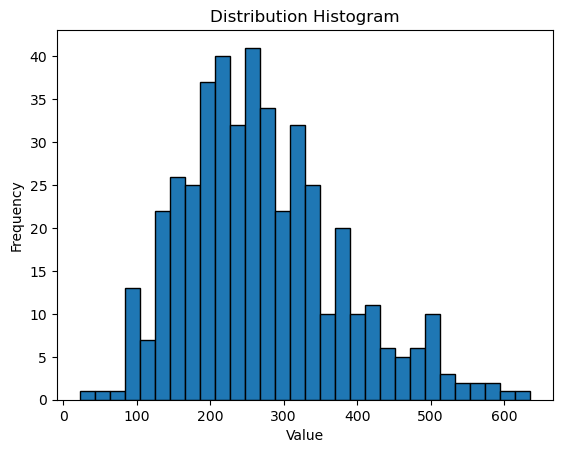

Chi-square statistic: 9.858882991080096, p-value: 0.04287306653772924


In [169]:
# Create the histogram
plt.hist(survey['time spend on all social media apps actual'], bins=30, edgecolor='black')
plt.title('Distribution Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Define percentiles
tercile1 = survey['time spend on all social media apps actual'].quantile(0.33)
tercile2 = survey['time spend on all social media apps actual'].quantile(0.66)

# Create the new variable
def categorize_usage(minutes):
    if minutes <= tercile1:
        return 0
    elif minutes <= tercile2:
        return 1
    else:
        return 2

survey['social_media_group'] = survey['time spend on all social media apps actual'].apply(categorize_usage)
# Create contingency table for risk-taking and social media usage
contingency_table = pd.crosstab(survey['risk_taking'], survey['social_media_group'])

# Perform Chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}, p-value: {p}")


In [70]:
# Create contingency table for framing risk-taking and social media usage
contingency_framing_table = pd.crosstab(survey['framing'], survey['social_media_group'])

# Perform Chi-square test
chi2, p, _, _ = chi2_contingency(contingency_framing_table)
print(f"Chi-square statistic: {chi2}, p-value: {p}")

Chi-square statistic: 2.990143490117569, p-value: 0.2242325165783362


In [71]:
lotteries = ['Q2','Q3','Q4','Q5','Q6','Q9_2','Q8','Q9','Q7a','Q7b']
# Hypothesis testing for each of the risk-taking tasks 

print("\nChi-square test for differences in Risk-taking tasks between High and Low Social Media Usage:")
for col in lotteries:
    # Create contingency table
    contingency_table = pd.crosstab(survey[col], survey['social_media_group'])
    
    # Perform Chi-square test
    chi2_stat, p_val, dof, ex = chi2_contingency(contingency_table)
    
    print(f"Chi-square test for {col}: chi2-stat={chi2_stat}, p-value={p_val}")


Chi-square test for differences in Risk-taking tasks between High and Low Social Media Usage:
Chi-square test for Q2: chi2-stat=2.400868954060443, p-value=0.3010633783696332
Chi-square test for Q3: chi2-stat=0.39504165819955295, p-value=0.8207630446943281
Chi-square test for Q4: chi2-stat=5.289963699304318, p-value=0.07100664252320182
Chi-square test for Q5: chi2-stat=2.6419684617233283, p-value=0.26687250850334787
Chi-square test for Q6: chi2-stat=0.9059862149575588, p-value=0.635722515342241
Chi-square test for Q9_2: chi2-stat=0.004199704266268087, p-value=0.9979023510139923
Chi-square test for Q8: chi2-stat=1.1878838426181515, p-value=0.5521464713199693
Chi-square test for Q9: chi2-stat=1.3554459765071796, p-value=0.5077718795549984
Chi-square test for Q7a: chi2-stat=0.2179796053782884, p-value=0.89673956178368
Chi-square test for Q7b: chi2-stat=1.2934262458287027, p-value=0.5237645001311816


In [156]:
# Prepare data for ordinal logistic regression
survey['social_media_group'] = survey['social_media_group'].astype('category').cat.codes
X = survey[['social_media_group', 'SEX', 'AGE']]
y = survey['risk_taking']

# Fit the ordinal logistic regression model
model = OrderedModel(y, X, distr='logit')
result = model.fit(method='bfgs')

# Display the summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.998497
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
                             OrderedModel Results                             
Dep. Variable:            risk_taking   Log-Likelihood:                -447.33
Model:                   OrderedModel   AIC:                             904.7
Method:            Maximum Likelihood   BIC:                             925.2
Date:                Mon, 05 Aug 2024                                         
Time:                        16:44:26                                         
No. Observations:                 448                                         
Df Residuals:                     443                                         
Df Model:                           3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

In [167]:
# Create the new variable
def categorize_usage(minutes):
    if minutes <= 200: #190,150
        return 0
    elif minutes <= 270: #270
        return 1
    else:
        return 2

survey['social_media_group'] = survey['time spend on all social media apps actual'].apply(categorize_usage)
# Create contingency table for risk-taking and social media usage
contingency_table = pd.crosstab(survey['risk_taking'], survey['social_media_group'])

# Perform Chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}, p-value: {p}")

Chi-square statistic: 12.862075846105958, p-value: 0.011969753167733124


In [184]:
# Prepare data for ordinal logistic regression
survey['social_media_group'] = survey['social_media_group'].astype('category').cat.codes
X = survey[['social_media_group', 'SEX', 'AGE']]
y = survey['risk_taking']

# Fit the ordinal logistic regression model
model = OrderedModel(y, X, distr='logit')
result = model.fit(method='bfgs')

# Display the summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.998497
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
                             OrderedModel Results                             
Dep. Variable:            risk_taking   Log-Likelihood:                -447.33
Model:                   OrderedModel   AIC:                             904.7
Method:            Maximum Likelihood   BIC:                             925.2
Date:                Wed, 07 Aug 2024                                         
Time:                        11:52:04                                         
No. Observations:                 448                                         
Df Residuals:                     443                                         
Df Model:                           3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

In [178]:
# Prepare data
survey['social_media_group'] = survey['social_media_group'].astype('category').cat.codes
X = survey[['social_media_group', 'SEX', 'AGE']]
y = survey['risk_taking']

# Add constant term for the intercept
X = sm.add_constant(X)

# Fit multinomial logistic regression model
mnlogit_model = sm.MNLogit(y, X).fit()
print(mnlogit_model.summary())

Optimization terminated successfully.
         Current function value: 0.984635
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:            risk_taking   No. Observations:                  448
Model:                        MNLogit   Df Residuals:                      440
Method:                           MLE   Df Model:                            6
Date:                Wed, 07 Aug 2024   Pseudo R-squ.:                 0.02696
Time:                        11:49:56   Log-Likelihood:                -441.12
converged:                       True   LL-Null:                       -453.34
Covariance Type:            nonrobust   LLR p-value:                 0.0004324
     risk_taking=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.5134      2.721      2.026      0.043       0.181      10.846
socia

In [183]:
# Prepare data for ordinal logistic regression
survey['social_media_group'] = survey['social_media_group'].astype('category').cat.codes
X = survey[['time spend on all social media apps actual', 'SEX', 'AGE']]
y = survey['risk_taking']

# Fit the ordinal logistic regression model
model = OrderedModel(y, X, distr='logit')
result = model.fit(method='bfgs')

# Display the summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 1.003647
         Iterations: 29
         Function evaluations: 33
         Gradient evaluations: 33
                             OrderedModel Results                             
Dep. Variable:            risk_taking   Log-Likelihood:                -449.63
Model:                   OrderedModel   AIC:                             909.3
Method:            Maximum Likelihood   BIC:                             929.8
Date:                Wed, 07 Aug 2024                                         
Time:                        11:51:11                                         
No. Observations:                 448                                         
Df Residuals:                     443                                         
Df Model:                           3                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
------

In [185]:
from sklearn.tree import DecisionTreeClassifier

# Train an ordinal decision tree classifier
model_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5)
model_tree.fit(X, y)

# Predict and evaluate
preds_tree = model_tree.predict(X)
accuracy_tree = accuracy_score(y, preds_tree)
conf_matrix_tree = confusion_matrix(y, preds_tree)
class_report_tree = classification_report(y, preds_tree)

print(f"Ordinal Decision Tree Accuracy: {accuracy_tree}")
print("\nConfusion Matrix:")
print(conf_matrix_tree)
print("\nClassification Report:")
print(class_report_tree)


Ordinal Decision Tree Accuracy: 0.5334821428571429

Confusion Matrix:
[[177   0  47]
 [ 58   0  17]
 [ 87   0  62]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.79      0.65       224
           1       0.00      0.00      0.00        75
           2       0.49      0.42      0.45       149

    accuracy                           0.53       448
   macro avg       0.35      0.40      0.37       448
weighted avg       0.44      0.53      0.47       448



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [180]:
from catboost import CatBoostClassifier

# Initialize CatBoost for ordinal data
model_catboost = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',  # CatBoost inherently supports ordinal targets
    eval_metric='Accuracy'
)

# Fit the model
model_catboost.fit(X, y, verbose=100, plot=True)

# Predict and evaluate
preds_catboost = model_catboost.predict(X)
accuracy_catboost = accuracy_score(y, preds_catboost)
conf_matrix_catboost = confusion_matrix(y, preds_catboost)
class_report_catboost = classification_report(y, preds_catboost)

print(f"CatBoost Accuracy: {accuracy_catboost}")
print("\nConfusion Matrix:")
print(conf_matrix_catboost)
print("\nClassification Report:")
print(class_report_catboost)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5000000	total: 7.59ms	remaining: 7.58s
100:	learn: 0.5468750	total: 32.6ms	remaining: 290ms
200:	learn: 0.5468750	total: 60.4ms	remaining: 240ms
300:	learn: 0.5468750	total: 88.1ms	remaining: 205ms
400:	learn: 0.5468750	total: 114ms	remaining: 170ms
500:	learn: 0.5468750	total: 142ms	remaining: 141ms
600:	learn: 0.5468750	total: 171ms	remaining: 113ms
700:	learn: 0.5468750	total: 203ms	remaining: 86.5ms
800:	learn: 0.5468750	total: 301ms	remaining: 74.7ms
900:	learn: 0.5468750	total: 385ms	remaining: 42.3ms
999:	learn: 0.5468750	total: 431ms	remaining: 0us
CatBoost Accuracy: 0.546875

Confusion Matrix:
[[198   5  21]
 [ 64   5   6]
 [104   3  42]]

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.88      0.67       224
           1       0.38      0.07      0.11        75
           2       0.61      0.28      0.39       149

    accuracy                           0.55       448
   macro avg       0.51      0.41   

In [186]:
# Assuming the predictions and accuracy values from the above models
accuracy_dict = {
    "Ordinal Logistic Regression": accuracy_ordinal,
    "Generalized Ordinal Logistic Regression": accuracy_gologit,
    "Multinomial Logistic Regression": accuracy_multinomial,
    "CatBoost": accuracy_catboost,
    "Ordinal Decision Tree": accuracy_tree,
    "Neural Network": accuracy_nn
}

# Print the comparison summary
print("\nComparison Summary:")
for model_name, accuracy in accuracy_dict.items():
    print(f"{model_name} Accuracy: {accuracy}")



Comparison Summary:
Ordinal Logistic Regression Accuracy: 0.515625
Generalized Ordinal Logistic Regression Accuracy: 0.140625
Multinomial Logistic Regression Accuracy: 0.140625
CatBoost Accuracy: 0.546875
Ordinal Decision Tree Accuracy: 0.5334821428571429
Neural Network Accuracy: 0.5


In [188]:
from catboost import cv

# Prepare data for cross-validation
train_data = Pool(data=X_train, label=y_train, cat_features=cat_features)

# Perform cross-validation
cv_params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'MultiClass',
    'eval_metric': 'Accuracy',
    'early_stopping_rounds': 50
}

cv_results = cv(train_data, cv_params, fold_count=5, plot=True)

print(cv_results)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.5034965	test: 0.5000000	best: 0.5000000 (0)	total: 6.84ms	remaining: 6.83s
1:	learn: 0.5244755	test: 0.4027778	best: 0.5000000 (0)	total: 10ms	remaining: 5s
2:	learn: 0.5139860	test: 0.4583333	best: 0.5000000 (0)	total: 12.8ms	remaining: 4.25s
3:	learn: 0.5034965	test: 0.5000000	best: 0.5000000 (0)	total: 14.4ms	remaining: 3.58s
4:	learn: 0.5139860	test: 0.5000000	best: 0.5000000 (0)	total: 17.3ms	remaining: 3.43s
5:	learn: 0.5069930	test: 0.5000000	best: 0.5000000 (0)	total: 17.5ms	remaining: 2.89s
6:	learn: 0.5034965	test: 0.5000000	best: 0.5000000 (0)	total: 17.7ms	remaining: 2.51s
7:	learn: 0.5034965	test: 0.5000000	best: 0.5000000 (0)	total: 18.1ms	remaining: 2.24s
8:	learn: 0.5069930	test: 0.5000000	best: 0.5000000 (0)	total: 19.9ms	remaining: 2.19s
9:	learn: 0.5139860	test: 0.5000000	best: 0.5000000 (0)	total: 21.6ms	remaining: 2.14s
10:	learn: 0.5139860	test: 0.5000000	best: 0.5000000 (0)	total: 23.7ms	remaining: 2.13s
11:	learn: 0.5069930	tes

In [ ]:
survey.rename(columns={'time spend on all social media apps actual': 'social_media_usage','Instagram actual':'Instagram','TikTok actual':'TikTok'}, inplace=True)
columns = ['social_media_usage','social_media_group','Instagram','TikTok' ,'risk_taking','framing','SEX','AGE']
n = len(columns)

# Create matrices to store correlation coefficients and p-values
correlation_matrix = np.zeros((n, n))
p_value_matrix = np.zeros((n, n))

# Calculate correlation coefficients and p-values
for i in range(n):
    for j in range(n):
        if i == j:
            correlation_matrix[i, j] = np.nan
            p_value_matrix[i, j] = np.nan
        else:
            corr, p_value = pearsonr(survey[columns[i]], survey[columns[j]])
            correlation_matrix[i, j] = corr
            p_value_matrix[i, j] = p_value

# Create a combined DataFrame for plotting
combined_df = pd.DataFrame({
    'Correlation': correlation_matrix.flatten(),
    'P-Value': p_value_matrix.flatten(),
    'Row': np.repeat(range(n), n),
    'Col': np.tile(range(n), n)
})

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Create a color map for p-values
cmap = plt.get_cmap('coolwarm')
norm = plt.Normalize(vmin=0, vmax=1)

# Create the heatmap
heatmap = ax.imshow(p_value_matrix, cmap=cmap, norm=norm, aspect='auto')

# Annotate with correlation coefficients and significance stars
for i in range(n):
    for j in range(n):
        if not np.isnan(correlation_matrix[i, j]):
            value = correlation_matrix[i, j]
            p_value = p_value_matrix[i, j]
            annotation = f'{value:.2f}'
            if p_value < 0.05:
                annotation += ' **'
            elif p_value < 0.1:
                annotation += ' *'
            ax.text(j, i, annotation,
                    ha='center', va='center', color='white')


# Add color bar and labels
cbar = plt.colorbar(heatmap, ax=ax, orientation='vertical')
cbar.set_label('P-Value')

ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(columns)
ax.set_yticklabels(columns)
ax.set_title('Correlation Coefficients with Significance Marked')

plt.show()